In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import itertools

import gtsam
import gtsam.utils.plot

import utils

In [4]:
plt.rcParams['figure.figsize'] = (20, 12)

In [7]:
image_dir = 'data/test_buddha_images/'

image_list = []
bgr_image_list = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for image_file_name in sorted(os.listdir(image_dir), reverse=True):
    image = cv2.imread(image_dir+image_file_name)
    bgr_image_list.append(image.astype(int))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(image)
    image_list.append(image)

# image_list = image_list[:-2]

image_height, image_width = image_list[0].shape

camera_matrix = np.array([[image_width, 0, image_width/2],
                          [0, image_width, image_height/2],
                          [0, 0, 1]])

In [8]:
def get_non_max_suppression_mask(keypoints):
    binary_image = np.zeros((image_height, image_width))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 3, 255, -1)

    return non_max_suppression_mask

In [27]:
# def get_tile_mask(keypoints):
    
#     binary_image = np.zeros((image_height, image_width))
#     response_list = np.array([keypoint.response for keypoint in keypoints])
#     mask = np.flip(np.argsort(response_list))
#     point_list = np.rint([keypoint.pt for keypoint in keypoints])[
#         mask].astype(int)
#     non_max_suppression_mask = []
#     for point, index in zip(point_list, mask):
#         if binary_image[point[1], point[0]] == 0:
#             non_max_suppression_mask.append(index)
#             cv2.circle(binary_image, (point[0], point[1]), 3, 255, -1)

#     return non_max_suppression_mask

In [9]:
sift = cv2.SIFT_create(nOctaveLayers=6)
# from MultiHarrisZernike import MultiHarrisZernike
# zernike_obj = MultiHarrisZernike(Nfeats=3000, seci=5, secj=4, levels=6, ratio=0.75,
#                                  sigi=2.75, sigd=1.0, nmax=8, like_matlab=False, lmax_nd=3, harris_threshold=None)

keypoints_list = []
descriptors_list = []
object_index_list = []

for image in image_list:
    keypoints, descriptors = sift.detectAndCompute(image, None)
    non_max_suppression_mask = get_non_max_suppression_mask(keypoints)

    keypoints_list.append(np.array(keypoints)[non_max_suppression_mask])
    descriptors_list.append(np.array(descriptors)[non_max_suppression_mask])

    object_index_list.append(np.full(len(keypoints), -1, int))

In [14]:
bf_matcher = cv2.BFMatcher(cv2.NORM_L2)


def get_match_points(src_keypoints, src_descriptors, dst_keypoints, dst_descriptors):

    matches = bf_matcher.knnMatch(src_descriptors, dst_descriptors, k=2)

    cross_matches = bf_matcher.match(dst_descriptors, src_descriptors)

    cross_match_dict = {}
    for cross_match in cross_matches:
        cross_match_dict[cross_match.trainIdx] = cross_match.queryIdx

    src_points = []
    dst_points = []
    src_point_index_list = []
    dst_point_index_list = []

    for match_1, match_2 in matches:
#         if match_1.queryIdx in cross_match_dict and cross_match_dict[match_1.queryIdx] == match_1.trainIdx and match_1.distance < 0.75*match_2.distance:
        if match_1.distance < 0.75*match_2.distance:
            src_points.append(src_keypoints[match_1.queryIdx].pt)
            dst_points.append(dst_keypoints[match_1.trainIdx].pt)
            src_point_index_list.append(match_1.queryIdx)
            dst_point_index_list.append(match_1.trainIdx)

    return np.array(src_points), np.array(dst_points), np.array(src_point_index_list), np.array(dst_point_index_list)

In [15]:
def get_pose_index_mask(dst_points, src_points):
    essential_matrix, essential_mask = cv2.findEssentialMat(
        dst_points, src_points, camera_matrix, cv2.RANSAC, 0.999, 1.0)

    essential_mask = np.squeeze(essential_mask != 0)

    index_mask = np.arange(len(src_points))

    index_mask = index_mask[essential_mask]
    src_points = src_points[essential_mask]
    dst_points = dst_points[essential_mask]

    _, rotation_matrix, translation, pose_mask = cv2.recoverPose(
        essential_matrix, dst_points, src_points, camera_matrix)

    pose_mask = np.squeeze(pose_mask != 0)
    
    return rotation_matrix, translation, index_mask[pose_mask]

In [16]:
symbol_X = gtsam.symbol_shorthand.X
symbol_L = gtsam.symbol_shorthand.L

gtsam_camera_matrix = gtsam.Cal3_S2(
    camera_matrix[0, 0], camera_matrix[1, 1], 0.0, camera_matrix[0, 2], camera_matrix[1, 2])

measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)

pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

graph = gtsam.NonlinearFactorGraph()

initial = gtsam.Values()

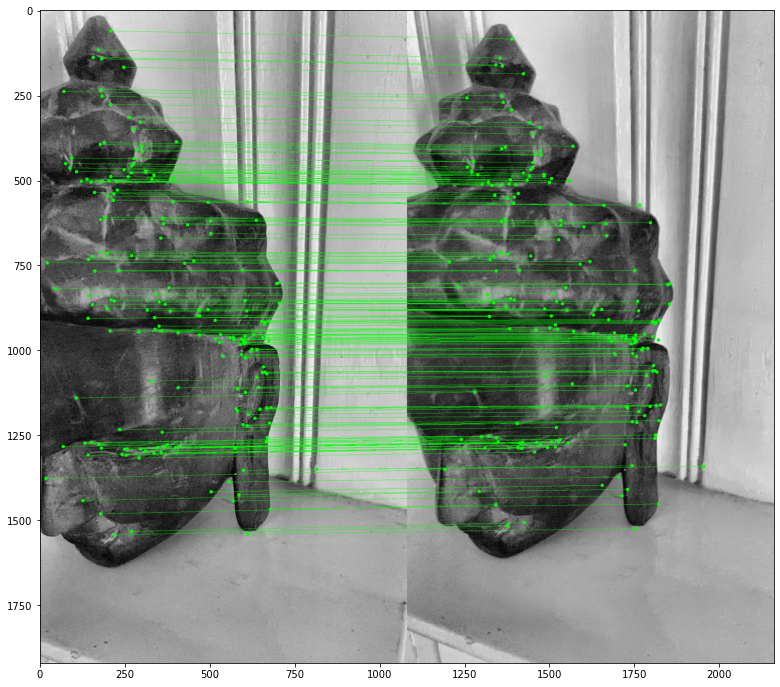

In [17]:
src_points, dst_points, src_point_index_list, dst_point_index_list = get_match_points(
    keypoints_list[0], descriptors_list[0], keypoints_list[1], descriptors_list[1])

rotation_matrix, translation, index_mask = get_pose_index_mask(
    dst_points, src_points)

src_points = src_points[index_mask]
dst_points = dst_points[index_mask]
src_point_index_list = src_point_index_list[index_mask]
dst_point_index_list = dst_point_index_list[index_mask]

utils.plot_match_points(image_list[0], image_list[1], src_points, dst_points)

In [18]:
def get_object_points(src_projection_matrix, dst_projection_matrix, src_points, dst_points):
    
    object_points = cv2.triangulatePoints(
        src_projection_matrix, dst_projection_matrix, src_points.T, dst_points.T)

    return (object_points/object_points[-1])[:-1].T

In [19]:
def get_transformation_matrix(rotation_matrix, translation):
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :] = np.hstack((rotation_matrix, translation))
    return transformation_matrix

In [20]:
def get_projection_matrix(transformation_matrix):
    return camera_matrix.dot(np.linalg.inv(transformation_matrix)[:3])
#     return camera_matrix.dot(transformation_matrix[:3])

In [21]:
transformation_matrix = get_transformation_matrix(rotation_matrix, translation)

pose_factor = gtsam.PriorFactorPose3(symbol_X(0), gtsam.Pose3(), pose_noise)
graph.push_back(pose_factor)

initial.insert(symbol_X(0), gtsam.Pose3())

initial.insert(symbol_X(1),
               gtsam.Pose3(gtsam.Rot3(rotation_matrix),
                           gtsam.Point3(translation.flatten())))

projection_matrix = get_projection_matrix(transformation_matrix)

sum_all_object_points = list(get_object_points(
    camera_matrix.dot(np.hstack((np.eye(3), np.zeros((3, 1))))), projection_matrix, src_points, dst_points))

prev_transformation_matrix = transformation_matrix.copy()
prev_projection_matrix = projection_matrix.copy()

point_factor = gtsam.PriorFactorPoint3(
    symbol_L(0), sum_all_object_points[0], point_noise)
graph.push_back(point_factor)

sum_all_object_points_color = []
all_object_points_count = []

src_object_index_array = object_index_list[0]
dst_object_index_array = object_index_list[1]
src_bgr_image = bgr_image_list[0]
dst_bgr_image = bgr_image_list[1]

rint_src_points = utils.get_rint(src_points)
rint_dst_points = utils.get_rint(dst_points)

for object_index, (src_point, dst_point, src_point_index, dst_point_index, object_point, rint_src_point, rint_dst_point) in enumerate(zip(src_points,
                                                                                                                                          dst_points,
                                                                                                                                          src_point_index_list,
                                                                                                                                          dst_point_index_list,
                                                                                                                                          sum_all_object_points,
                                                                                                                                          rint_src_points,
                                                                                                                                          rint_dst_points)):
    print(object_index)
    src_object_index_array[src_point_index] = object_index
    dst_object_index_array[dst_point_index] = object_index

    graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
        src_point, measurement_noise, symbol_X(0), symbol_L(object_index), gtsam_camera_matrix))

    graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
        dst_point, measurement_noise, symbol_X(1), symbol_L(object_index), gtsam_camera_matrix))

    sum_all_object_points_color.append(
        src_bgr_image[rint_src_point[1], rint_src_point[0]]+dst_bgr_image[rint_dst_point[1], rint_dst_point[0]])

    all_object_points_count.append(2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182


In [38]:
for src_index in range(1, len(image_list)-1):

    dst_index = src_index+1

    src_points, dst_points, src_point_index_list, dst_point_index_list = get_match_points(
        keypoints_list[src_index], descriptors_list[src_index], keypoints_list[dst_index], descriptors_list[dst_index])

    rotation_matrix, translation, index_mask = get_pose_index_mask(
        dst_points, src_points)

    src_points = src_points[index_mask]
    dst_points = dst_points[index_mask]
    src_point_index_list = src_point_index_list[index_mask]
    dst_point_index_list = dst_point_index_list[index_mask]

    utils.plot_match_points(
        image_list[src_index], image_list[dst_index], src_points, dst_points)

    transformation_matrix = get_transformation_matrix(
        rotation_matrix, translation).dot(prev_transformation_matrix)
#     transformation_matrix = prev_transformation_matrix.dot(
#         get_transformation_matrix(rotation_matrix, translation))
    projection_matrix = get_projection_matrix(transformation_matrix)

    match_src_points = []
    match_dst_points = []
    match_object_points = []

    src_object_index_array = object_index_list[src_index]
    dst_object_index_array = object_index_list[dst_index]
    src_bgr_image = bgr_image_list[src_index]
    dst_bgr_image = bgr_image_list[dst_index]

    for src_point, dst_point, src_point_index in zip(src_points, dst_points, src_point_index_list):

        object_index = src_object_index_array[src_point_index]
        if object_index != -1:
            match_src_points.append(src_point)
            match_dst_points.append(dst_point)
            match_object_points.append(
                sum_all_object_points[object_index]/(all_object_points_count[object_index]-1))

    match_src_points = np.array(match_src_points)
    match_dst_points = np.array(match_dst_points)
    match_object_points = np.array(match_object_points)

    object_points = get_object_points(
        prev_projection_matrix, projection_matrix, match_src_points, match_dst_points)

#     test_scale=0
#     test_count = 0
#     for pair_index_1, pair_index_2 in itertools.combinations(range(len(object_points)), 2):
#         test_scale += cv2.norm(match_object_points[pair_index_1]-match_object_points[pair_index_2])/cv2.norm(
#             object_points[pair_index_1]-object_points[pair_index_2])
#         test_count += 1
#     print(test_scale/test_count)

    scale = 0
    for match_object_point, object_point in zip(match_object_points, object_points):
        scale += cv2.norm(match_object_point)/cv2.norm(object_point)

    scale /= len(object_points)
    print(scale)
    print('---')

#     scale = 1

#     print(translation)

    translation *= scale

    transformation_matrix = get_transformation_matrix(
        rotation_matrix, translation).dot(prev_transformation_matrix)
#     transformation_matrix = prev_transformation_matrix.dot(
#         get_transformation_matrix(rotation_matrix, translation))

#     print(transformation_matrix[2, 3])

    initial.insert(symbol_X(dst_index),
                   gtsam.Pose3(gtsam.Rot3(transformation_matrix[:3, :3]),
                               gtsam.Point3(transformation_matrix[:3, 3])))

    projection_matrix = get_projection_matrix(transformation_matrix)

    object_points = get_object_points(
        prev_projection_matrix, projection_matrix, src_points, dst_points)

    prev_transformation_matrix = transformation_matrix.copy()
    prev_projection_matrix = projection_matrix.copy()

    rint_src_points = utils.get_rint(src_points)
    rint_dst_points = utils.get_rint(dst_points)

    current_object_index = len(all_object_points_count)

    for src_point, dst_point, src_point_index, dst_point_index, object_point, rint_src_point, rint_dst_point in zip(src_points,
                                                                                                                    dst_points,
                                                                                                                    src_point_index_list,
                                                                                                                    dst_point_index_list,
                                                                                                                    object_points,
                                                                                                                    rint_src_points,
                                                                                                                    rint_dst_points):
        object_index = src_object_index_array[src_point_index]
        if object_index == -1:

            object_index = current_object_index

            sum_all_object_points.append(object_point)
            sum_all_object_points_color.append(
                src_bgr_image[rint_src_point[1], rint_src_point[0]] + dst_bgr_image[rint_dst_point[1], rint_dst_point[0]])
            all_object_points_count.append(2)

            src_object_index_array[src_point_index] = dst_object_index_array[
                dst_point_index] = object_index

            current_object_index += 1
        else:
            dst_object_index_array[dst_point_index] = object_index

            sum_all_object_points[object_index] += object_point
            sum_all_object_points_color[object_index] += dst_bgr_image[rint_dst_point[1],
                                                                       rint_dst_point[0]]
            all_object_points_count[object_index] += 1

        graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
            src_point, measurement_noise, symbol_X(src_index), symbol_L(object_index), gtsam_camera_matrix))

        graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
            dst_point, measurement_noise, symbol_X(dst_index), symbol_L(object_index), gtsam_camera_matrix))

0.6581950393020237
---
1.1241229971998616
---
0.8002818539488767
---
1.6999566926340004
---
0.9508313247877612
---
0.5046593783096534
---
1.0206423108968188
---
1.1441777058036902
---
1.5805348837464115
---
1.1547047660846086
---
1.0745987279559435
---
1.0953267223238716
---
0.9649680732007306
---
0.8187017949306737
---
1.1539597297202067
---
0.6433626624136918
---
0.8274319830420783
---
1.3457275243634776
---
1.0267753531937032
---
0.14127841630791013
---


error: OpenCV(4.10.0) /io/opencv/modules/calib3d/src/triangulate.cpp:64: error: (-210:Unsupported format or combination of formats) Input parameters must be matrices in function 'icvTriangulatePoints'


In [21]:
all_object_points_count = np.array(
    [all_object_points_count, all_object_points_count, all_object_points_count]).T

all_object_points = np.array(sum_all_object_points)/(all_object_points_count-1)
all_object_points_color = np.flip(np.array(
    sum_all_object_points_color)/all_object_points_count).astype(np.uint8)

for object_index, object_point in enumerate(all_object_points):
    initial.insert(symbol_L(object_index),
                   gtsam.Point3(object_point))

params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()

print(result)

Values with 2514 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-4.39151;
	-11.8757;
	16.1947
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1.37328;
	-4.87375;
	15.4473
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.63034;
	0.231524;
	21.2566
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.06907;
	-0.0697941;
	16.3715
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-2.62093;
	4.94728;
	16.4333
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-4.33695;
	-5.35702;
	14.4257
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-3.67729;
	-7.03753;
	14.9554
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-6.35146;
	-6.98444;
	15.1824
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-3.73198;
	-8.59728;
	15.2175
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-5.4833;
	-1.65697;
	14.8609
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	1.09598;
	0.294254;
	19.6938
]

Value l11: (Eigen::M

In [22]:
%matplotlib tk

fig = plt.figure()
ax = fig.gca(projection='3d')

final_object_points = []
for index in range(len(all_object_points)):
    final_object_points.append(result.atPoint3(symbol_L(index)))

final_object_points = np.array(final_object_points)

ax.scatter(final_object_points[:, 0],
           final_object_points[:, 1], final_object_points[:, 2], c=all_object_points_color/255., s=3)

# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)

ax.set_xlim3d(-40, 20)
ax.set_ylim3d(-30, 20)
ax.set_zlim3d(-10, 40)


plt.show()

/tmp/ipykernel_7514/3861496748.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [40]:
H = 4
M = 1

new_H = 11 - H if M>0 else 12 - H
new_M = 60 - M if M>0 else 0

if new_H <=0:
    new_H = 12 + new_H

print(new_H, new_M)

7 59
